# New model

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, 
                                   Dropout, BatchNormalization, GlobalAveragePooling2D)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau, ModelCheckpoint)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

## Load and preprocessing data

In [2]:
def load_and_preprocess_data():
    """Load data with improved preprocessing"""
    try:
        X_train = np.loadtxt('input.csv', delimiter=',')
        X_test = np.loadtxt('input_test.csv', delimiter=',')
        Y_train = np.loadtxt('labels.csv', delimiter=',')
        Y_test = np.loadtxt('labels_test.csv', delimiter=',')
    except ValueError:
        import pandas as pd
        X_train = pd.read_csv('input.csv').to_numpy()
        X_test = pd.read_csv('input_test.csv').to_numpy()
        Y_train = pd.read_csv('labels.csv').to_numpy()
        Y_test = pd.read_csv('labels_test.csv').to_numpy()
    
    # Reshape data
    X_train = X_train.reshape(-1, 100, 100, 3)
    X_test = X_test.reshape(-1, 100, 100, 3)
    Y_train = Y_train.reshape(-1, 1)
    Y_test = Y_test.reshape(-1, 1)
    
    # Normalize pixel values
    X_train = X_train.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0
    
    # Per-channel normalization 
    # Compute mean and std per channel on training data
    train_mean = np.mean(X_train, axis=(0, 1, 2))
    train_std = np.std(X_train, axis=(0, 1, 2))
    
    # Apply normalization
    X_train = (X_train - train_mean) / (train_std + 1e-7)
    X_test = (X_test - train_mean) / (train_std + 1e-7)
    
    print(f"Training data shape: {X_train.shape}")
    print(f"Test data shape: {X_test.shape}")
    print(f"Training labels distribution: {np.bincount(Y_train.astype(int).flatten())}")
    
    return X_train, X_test, Y_train, Y_test

# data augmentatio

In [3]:
def create_data_generators(X_train, Y_train, X_test, Y_test):
    """Create data generators with more aggressive augmentation"""
    train_datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.3,
        height_shift_range=0.3,
        horizontal_flip=True,
        zoom_range=0.3,
        shear_range=0.2,
        brightness_range=[0.8, 1.2],
        fill_mode='nearest'
    )
    
    # No augmentation for validation data
    val_datagen = ImageDataGenerator()
    
    train_generator = train_datagen.flow(X_train, Y_train, batch_size=32)
    val_generator = val_datagen.flow(X_test, Y_test, batch_size=32, shuffle=False)
    
    return train_generator, val_generator


# CNN architecture

In [4]:
def create_improved_model():
    """Create an improved CNN model with better architecture"""
    model = Sequential([
        # First Convolutional Block
        Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Second Convolutional Block
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Third Convolutional Block
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Fourth Convolutional Block
        Conv2D(256, (3, 3), activation='relu'),
        BatchNormalization(),
        Dropout(0.25),
        
        # Global Average Pooling instead of Flatten
        GlobalAveragePooling2D(),
        
        # Dense layers
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    return model


# Transfer learning model (VGG16-based)

In [5]:
def create_transfer_learning_model():
    """Create a transfer learning model using VGG16"""
    from tensorflow.keras.applications import VGG16
    from tensorflow.keras.models import Model
    
    # Load pre-trained VGG16 model
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(100, 100, 3))
    
    # Freeze early layers
    for layer in base_model.layers[:-4]:
        layer.trainable = False
    
    # Add custom classifier
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Training 

In [6]:
def train_model(model, train_generator, val_generator, model_name="enhanced_model"):
    """Train the model with advanced callbacks"""
    
    # Compile with optimized parameters
    optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    # Advanced callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_accuracy',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        ),
        ModelCheckpoint(
            f'{model_name}_best.h5',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        )
    ]
    
    # Train the model
    history = model.fit(
        train_generator,
        epochs=100,  # More epochs with early stopping
        validation_data=val_generator,
        callbacks=callbacks,
        verbose=1
    )
    
    return history


# Evaluation and visualization

In [7]:
def evaluate_and_visualize(model, X_test, Y_test):
    """Comprehensive model evaluation"""
    
    # Make predictions
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)
    
    # Calculate accuracy
    accuracy = np.mean(y_pred.flatten() == Y_test.flatten())
    print(f"Final Test Accuracy: {accuracy:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(Y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Dog', 'Cat'], yticklabels=['Dog', 'Cat'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix - Enhanced Model')
    plt.show()
    
    # Classification Report
    print("\nClassification Report:")
    print(classification_report(Y_test, y_pred, target_names=['Dog', 'Cat']))
    
    return accuracy


# Ensemble method

In [8]:
def create_ensemble_prediction(models, X_test):
    """Create ensemble predictions from multiple models"""
    predictions = []
    
    for model in models:
        pred = model.predict(X_test)
        predictions.append(pred)
    
    # Average predictions
    ensemble_pred = np.mean(predictions, axis=0)
    return (ensemble_pred > 0.5).astype(int)

# Main execution function
def main():
    """Main function to run the entire pipeline"""
    
    print("="*50)
    print("ENHANCED DOG VS CAT CLASSIFICATION")
    print("="*50)
    
    # Step 1: Load and preprocess data
    print("\n1. Loading and preprocessing data...")
    X_train, X_test, Y_train, Y_test = load_and_preprocess_data()
    
    # Step 2: Create data generators
    print("\n2. Creating data generators...")
    train_gen, val_gen = create_data_generators(X_train, Y_train, X_test, Y_test)
    
    # Step 3: Train improved CNN model
    print("\n3. Training improved CNN model...")
    improved_model = create_improved_model()
    print(f"Model parameters: {improved_model.count_params():,}")
    
    history1 = train_model(improved_model, train_gen, val_gen, "improved_cnn")
    acc1 = evaluate_and_visualize(improved_model, X_test, Y_test)
    
    # Step 4: Train transfer learning model
    print("\n4. Training transfer learning model...")
    transfer_model = create_transfer_learning_model()
    print(f"Transfer model parameters: {transfer_model.count_params():,}")
    
    # Recreate generators for transfer learning
    train_gen2, val_gen2 = create_data_generators(X_train, Y_train, X_test, Y_test)
    history2 = train_model(transfer_model, train_gen2, val_gen2, "transfer_learning")
    acc2 = evaluate_and_visualize(transfer_model, X_test, Y_test)
    

# prediction

In [10]:
def create_ensemble_prediction(models, X_test):
    """Create ensemble predictions from multiple models"""
    predictions = []
    
    for model in models:
        pred = model.predict(X_test)
        predictions.append(pred)
    
    # Average predictions
    ensemble_pred = np.mean(predictions, axis=0)
    return (ensemble_pred > 0.5).astype(int)

# Main execution function
def main():
    """Main function to run the entire pipeline"""
    
    print("="*50)
    print("ENHANCED DOG VS CAT CLASSIFICATION")
    print("="*50)
    
    # Step 1: Load and preprocess data
    print("\n1. Loading and preprocessing data...")
    X_train, X_test, Y_train, Y_test = load_and_preprocess_data()
    
    # Step 2: Create data generators
    print("\n2. Creating data generators...")
    train_gen, val_gen = create_data_generators(X_train, Y_train, X_test, Y_test)
    
    # Step 3: Train improved CNN model
    print("\n3. Training improved CNN model...")
    improved_model = create_improved_model()
    print(f"Model parameters: {improved_model.count_params():,}")
    
    history1 = train_model(improved_model, train_gen, val_gen, "improved_cnn")
    acc1 = evaluate_and_visualize(improved_model, X_test, Y_test)
    
    # Step 4: Train transfer learning model
    print("\n4. Training transfer learning model...")
    transfer_model = create_transfer_learning_model()
    print(f"Transfer model parameters: {transfer_model.count_params():,}")
    
    # Recreate generators for transfer learning
    train_gen2, val_gen2 = create_data_generators(X_train, Y_train, X_test, Y_test)
    history2 = train_model(transfer_model, train_gen2, val_gen2, "transfer_learning")
    acc2 = evaluate_and_visualize(transfer_model, X_test, Y_test)
    
    # Step 5: Ensemble prediction
    print("\n5. Creating ensemble prediction...")
    ensemble_pred = create_ensemble_prediction([improved_model, transfer_model], X_test)
    ensemble_acc = np.mean(ensemble_pred.flatten() == Y_test.flatten())
    print(f"Ensemble Accuracy: {ensemble_acc:.4f}")
    
    # Final comparison
    print("\n" + "="*50)
    print("FINAL RESULTS COMPARISON:")
    print("="*50)
    print(f"Improved CNN Accuracy: {acc1:.4f}")
    print(f"Transfer Learning Accuracy: {acc2:.4f}")
    print(f"Ensemble Accuracy: {ensemble_acc:.4f}")
    print("="*50)
    
    return improved_model, transfer_model, ensemble_acc

# Additional utility functions
def plot_training_history(history):
    """Plot training history"""
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def show_prediction_examples(model, X_test, Y_test, num_examples=8):
    """Show prediction examples"""
    indices = np.random.choice(len(X_test), num_examples, replace=False)
    
    plt.figure(figsize=(16, 8))
    for i, idx in enumerate(indices):
        plt.subplot(2, 4, i+1)
        
        # Denormalize image for display (if normalized)
        img = X_test[idx]
        if img.min() < 0:  # If normalized
            img = (img - img.min()) / (img.max() - img.min())
        
        plt.imshow(img)
        
        pred_prob = model.predict(np.expand_dims(X_test[idx], axis=0))[0][0]
        pred_class = "Cat" if pred_prob > 0.5 else "Dog"
        true_class = "Cat" if Y_test[idx][0] > 0.5 else "Dog"
        
        color = 'green' if pred_class == true_class else 'red'
        plt.title(f'True: {true_class}\nPred: {pred_class} ({pred_prob:.2f})', 
                 color=color)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Main

ENHANCED DOG VS CAT CLASSIFICATION

1. Loading and preprocessing data...
Training data shape: (2000, 100, 100, 3)
Test data shape: (400, 100, 100, 3)
Training labels distribution: [1000 1000]

2. Creating data generators...

3. Training improved CNN model...


d:\Code\DogVsCat-classification-using-CNN\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model parameters: 849,313


d:\Code\DogVsCat-classification-using-CNN\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.5129 - loss: 1.1007
Epoch 1: val_accuracy improved from None to 0.56000, saving model to improved_cnn_best.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 245ms/step - accuracy: 0.5010 - loss: 1.0985 - val_accuracy: 0.5600 - val_loss: 0.6893 - learning_rate: 0.0010
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.5312 - loss: 0.9411
Epoch 2: val_accuracy did not improve from 0.56000
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 242ms/step - accuracy: 0.5220 - loss: 0.9261 - val_accuracy: 0.5100 - val_loss: 0.7063 - learning_rate: 0.0010
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.5429 - loss: 0.9153
Epoch 3: val_accuracy did not improve from 0.56000
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 231ms/step - accuracy: 0.5410 - loss: 0.8696 - val_accuracy: 0.4950 - val_loss: 0.8943 - learning_rate: 0.0010
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.5551 - loss: 0.8142
Epoch 4: val_accuracy did not improve from 0.56000
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 231ms/step - accuracy: 0.5505 - loss: 0.8164 - val_accuracy: 0.5350 - val_loss: 0.6909 - learning_rate: 0.0010
Epoch 5/100
63/63 

63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 235ms/step - accuracy: 0.5800 - loss: 0.7309 - val_accuracy: 0.5775 - val_loss: 0.6609 - learning_rate: 0.0010
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.5710 - loss: 0.7263
Epoch 7: val_accuracy did not improve from 0.57750
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 235ms/step - accuracy: 0.5810 - loss: 0.7236 - val_accuracy: 0.5750 - val_loss: 0.7317 - learning_rate: 0.0010
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.6063 - loss: 0.7066
Epoch 8: val_accuracy improved from 0.57750 to 0.60750, saving model to improved_cnn_best.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 233ms/step - accuracy: 0.5930 - loss: 0.6993 - val_accuracy: 0.6075 - val_loss: 0.6607 - learning_rate: 0.0010
Epoch 9/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.6184 - loss: 0.6427
Epoch 9: val_accuracy did not improve from 0.60750
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 231ms/step - accuracy: 0.6125 - loss: 0.6665 - val_accuracy: 0.5875 - val_loss: 0.7125 - learning_rate: 0.0010
Epoch 10/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.6078 - loss: 0.6725
Epoch 10: val_accuracy improved from 0.60750 to 0.61250, saving model to improved_cnn_best.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 238ms/step - accuracy: 0.6210 - loss: 0.6635 - val_accuracy: 0.6125 - val_loss: 0.6439 - learning_rate: 0.0010
Epoch 11/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.6090 - loss: 0.6711
Epoch 11: val_accuracy improved from 0.61250 to 0.63000, saving model to improved_cnn_best.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 234ms/step - accuracy: 0.6110 - loss: 0.6706 - val_accuracy: 0.6300 - val_loss: 0.6317 - learning_rate: 0.0010
Epoch 12/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.6340 - loss: 0.6786
Epoch 12: val_accuracy did not improve from 0.63000
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 237ms/step - accuracy: 0.6395 - loss: 0.6582 - val_accuracy: 0.5850 - val_loss: 0.6815 - learning_rate: 0.0010
Epoch 13/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.6354 - loss: 0.6425
Epoch 13: val_accuracy improved from 0.63000 to 0.63250, saving model to improved_cnn_best.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 235ms/step - accuracy: 0.6325 - loss: 0.6451 - val_accuracy: 0.6325 - val_loss: 0.6258 - learning_rate: 0.0010
Epoch 14/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.6171 - loss: 0.6528
Epoch 14: val_accuracy improved from 0.63250 to 0.67000, saving model to improved_cnn_best.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 246ms/step - accuracy: 0.6315 - loss: 0.6431 - val_accuracy: 0.6700 - val_loss: 0.6079 - learning_rate: 0.0010
Epoch 15/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.6520 - loss: 0.6355
Epoch 15: val_accuracy did not improve from 0.67000
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 239ms/step - accuracy: 0.6485 - loss: 0.6351 - val_accuracy: 0.6050 - val_loss: 0.6643 - learning_rate: 0.0010
Epoch 16/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.6386 - loss: 0.6367
Epoch 16: val_accuracy improved from 0.67000 to 0.70250, saving model to improved_cnn_best.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 242ms/step - accuracy: 0.6465 - loss: 0.6458 - val_accuracy: 0.7025 - val_loss: 0.5862 - learning_rate: 0.0010
Epoch 17/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.6214 - loss: 0.6458
Epoch 17: val_accuracy did not improve from 0.70250
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 233ms/step - accuracy: 0.6235 - loss: 0.6413 - val_accuracy: 0.6325 - val_loss: 0.6397 - learning_rate: 0.0010
Epoch 18/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.6498 - loss: 0.6221
Epoch 18: val_accuracy did not improve from 0.70250
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 231ms/step - accuracy: 0.6370 - loss: 0.6379 - val_accuracy: 0.5800 - val_loss: 0.6557 - learning_rate: 0.0010
Epoch 19/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.6475 - loss: 0.6291
Epoch 19: val_accuracy did not improve from 0.70250
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 228ms/step - accuracy: 0.6485 - loss: 0.6311 - val_accuracy: 0.6400 - val_loss: 0.6154 - learning_rate: 0.0010
Epoch 20/100

63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 233ms/step - accuracy: 0.6845 - loss: 0.5914 - val_accuracy: 0.7400 - val_loss: 0.5311 - learning_rate: 5.0000e-04
Epoch 26/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.6739 - loss: 0.5972
Epoch 26: val_accuracy improved from 0.74000 to 0.75500, saving model to improved_cnn_best.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 238ms/step - accuracy: 0.6815 - loss: 0.5928 - val_accuracy: 0.7550 - val_loss: 0.5317 - learning_rate: 5.0000e-04
Epoch 27/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.6805 - loss: 0.6005
Epoch 27: val_accuracy did not improve from 0.75500
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 236ms/step - accuracy: 0.6875 - loss: 0.5909 - val_accuracy: 0.6400 - val_loss: 0.6162 - learning_rate: 5.0000e-04
Epoch 28/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.6871 - loss: 0.5887
Epoch 28: val_accuracy did not improve from 0.75500
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 229ms/step - accuracy: 0.6770 - loss: 0.5945 - val_accuracy: 0.6875 - val_loss: 0.5793 - learning_rate: 5.0000e-04
Epoch 29/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.7063 - loss: 0.5713
Epoch 29: val_accuracy did not improve from 0.75500
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 229ms/step - accuracy: 0.6980 - loss: 0.5788 - val_accuracy: 0.6475 - val_loss: 0.6578 - learning_rate: 5.0000e

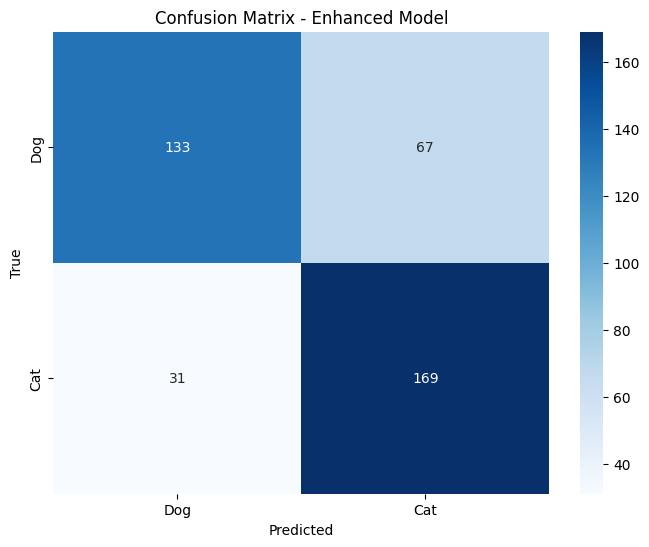


Classification Report:
              precision    recall  f1-score   support

         Dog       0.81      0.67      0.73       200
         Cat       0.72      0.84      0.78       200

    accuracy                           0.76       400
   macro avg       0.76      0.76      0.75       400
weighted avg       0.76      0.76      0.75       400


4. Training transfer learning model...
Transfer model parameters: 15,110,977
Epoch 1/100


d:\Code\DogVsCat-classification-using-CNN\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.6423 - loss: 0.7242
Epoch 1: val_accuracy improved from None to 0.69500, saving model to transfer_learning_best.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 513ms/step - accuracy: 0.6925 - loss: 0.6389 - val_accuracy: 0.6950 - val_loss: 1.6157 - learning_rate: 0.0010
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.8318 - loss: 0.4099
Epoch 2: val_accuracy did not improve from 0.69500
63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 492ms/step - accuracy: 0.8125 - loss: 0.4442 - val_accuracy: 0.6125 - val_loss: 2.6064 - learning_rate: 0.0010
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.8342 - loss: 0.4292
Epoch 3: val_accuracy did not improve from 0.69500
63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 499ms/step - accuracy: 0.8280 - loss: 0.4122 - val_accuracy: 0.5950 - val_loss: 2.8067 - learning_rate: 0.0010
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.8450 - loss: 0.3697
Epoch 4: val_accuracy improved from 0.69500 to 0.73750, saving model to transfer_learning_best.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 499ms/step - accuracy: 0.8535 - loss: 0.3533 - val_accuracy: 0.7375 - val_loss: 1.0392 - learning_rate: 0.0010
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.8601 - loss: 0.3369
Epoch 5: val_accuracy improved from 0.73750 to 0.81000, saving model to transfer_learning_best.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 488ms/step - accuracy: 0.8565 - loss: 0.3367 - val_accuracy: 0.8100 - val_loss: 0.5689 - learning_rate: 0.0010
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.8756 - loss: 0.3039
Epoch 6: val_accuracy improved from 0.81000 to 0.87250, saving model to transfer_learning_best.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 491ms/step - accuracy: 0.8745 - loss: 0.3039 - val_accuracy: 0.8725 - val_loss: 0.3696 - learning_rate: 0.0010
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.8706 - loss: 0.3261
Epoch 7: val_accuracy improved from 0.87250 to 0.88250, saving model to transfer_learning_best.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 496ms/step - accuracy: 0.8680 - loss: 0.3192 - val_accuracy: 0.8825 - val_loss: 0.3466 - learning_rate: 0.0010
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.8848 - loss: 0.2867
Epoch 8: val_accuracy improved from 0.88250 to 0.91750, saving model to transfer_learning_best.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 488ms/step - accuracy: 0.8810 - loss: 0.2877 - val_accuracy: 0.9175 - val_loss: 0.2002 - learning_rate: 0.0010
Epoch 9/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.9010 - loss: 0.2576
Epoch 9: val_accuracy did not improve from 0.91750
63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 488ms/step - accuracy: 0.8815 - loss: 0.2916 - val_accuracy: 0.8825 - val_loss: 0.3305 - learning_rate: 0.0010
Epoch 10/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.8734 - loss: 0.2887
Epoch 10: val_accuracy did not improve from 0.91750
63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 488ms/step - accuracy: 0.8850 - loss: 0.2738 - val_accuracy: 0.8150 - val_loss: 0.5236 - learning_rate: 0.0010
Epoch 11/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.8922 - loss: 0.2643
Epoch 11: val_accuracy did not improve from 0.91750
63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 486ms/step - accuracy: 0.8850 - loss: 0.2709 - val_accuracy: 0.9150 - val_loss: 0.2006 - learning_rate: 0.0010
Epoch 12/100
6

63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 494ms/step - accuracy: 0.9225 - loss: 0.2139 - val_accuracy: 0.9425 - val_loss: 0.1679 - learning_rate: 5.0000e-04
Epoch 15/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.9232 - loss: 0.1983
Epoch 15: val_accuracy improved from 0.94250 to 0.94500, saving model to transfer_learning_best.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 492ms/step - accuracy: 0.9130 - loss: 0.2247 - val_accuracy: 0.9450 - val_loss: 0.1573 - learning_rate: 5.0000e-04
Epoch 16/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.9211 - loss: 0.1849
Epoch 16: val_accuracy did not improve from 0.94500
63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 495ms/step - accuracy: 0.9195 - loss: 0.1919 - val_accuracy: 0.8750 - val_loss: 0.2682 - learning_rate: 5.0000e-04
Epoch 17/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.9268 - loss: 0.1835
Epoch 17: val_accuracy did not improve from 0.94500
63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 487ms/step - accuracy: 0.9270 - loss: 0.1821 - val_accuracy: 0.9400 - val_loss: 0.1784 - learning_rate: 5.0000e-04
Epoch 18/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.9102 - loss: 0.2160
Epoch 18: val_accuracy did not improve from 0.94500
63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 488ms/step - accuracy: 0.9215 - loss: 0.2042 - val_accuracy: 0.9425 - val_loss: 0.1643 - learning_rate: 5.0000e

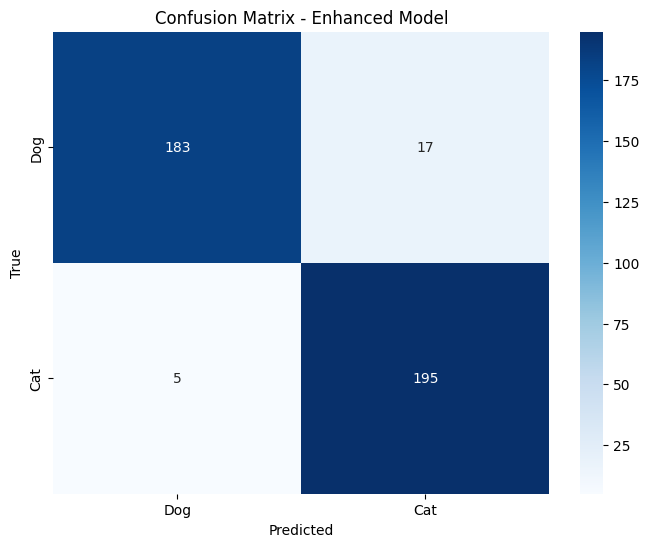


Classification Report:
              precision    recall  f1-score   support

         Dog       0.97      0.92      0.94       200
         Cat       0.92      0.97      0.95       200

    accuracy                           0.94       400
   macro avg       0.95      0.95      0.94       400
weighted avg       0.95      0.94      0.94       400


5. Creating ensemble prediction...
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 329ms/step
Ensemble Accuracy: 0.9350

FINAL RESULTS COMPARISON:
Improved CNN Accuracy: 0.7550
Transfer Learning Accuracy: 0.9450
Ensemble Accuracy: 0.9350


In [11]:
if __name__ == "__main__":
    improved_model, transfer_model, final_accuracy = main()